In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, LSTM, Conv1D, Reshape, MaxPooling1D, TimeDistributed, Bidirectional
from keras.layers import Input
from keras.applications import VGG16, ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint



These settings are crucial for preparing the data before it is fed into the neural network for training and evaluation. The image dimensions need to be uniform, and the batch size affects the memory usage and speed of training. 

In [2]:
img_height, img_width = 224, 224
batch_size = 32
data_dir = 'FCGR_Analysiss_k3'

These generators handle the loading and preprocessing of images for training, validation, and testing. The images are resized to a consistent size, normalized, and loaded in batches, which facilitates efficient model training and evaluation.

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(data_dir, 'validation'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(data_dir, 'test'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 2032 images belonging to 2 classes.
Found 434 images belonging to 2 classes.
Found 438 images belonging to 2 classes.


simple CNN Model Architecture : 
The model is built using the Sequential API, which allows for a linear stack of layers.

In [4]:
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

Callbacks: Monitors the validation loss during training and stops training early if the validation loss does not improve for a specified number of epochs (patience).
ReduceLROnPlateau: Reduces the learning rate when the validation loss has stopped improving.

In [5]:
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.2, min_lr=1e-6),
    ModelCheckpoint('best_cnn_model.h5', save_best_only=True)
]

history_cnn = cnn_model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=callbacks
)


Epoch 1/100
64/64 [==============================] - 50s 774ms/step - loss: 0.7004 - accuracy: 0.4774 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/100
64/64 [==============================] - 45s 708ms/step - loss: 0.6927 - accuracy: 0.5108 - val_loss: 0.6929 - val_accuracy: 0.5369 - lr: 1.0000e-04
Epoch 3/100
64/64 [==============================] - 45s 709ms/step - loss: 0.6920 - accuracy: 0.5266 - val_loss: 0.6920 - val_accuracy: 0.5069 - lr: 1.0000e-04
Epoch 4/100
64/64 [==============================] - 45s 701ms/step - loss: 0.6885 - accuracy: 0.5517 - val_loss: 0.6891 - val_accuracy: 0.5276 - lr: 1.0000e-04
Epoch 5/100
64/64 [==============================] - 45s 705ms/step - loss: 0.6761 - accuracy: 0.6097 - val_loss: 0.6789 - val_accuracy: 0.5737 - lr: 1.0000e-04
Epoch 6/100
64/64 [==============================] - 45s 701ms/step - loss: 0.6531 - accuracy: 0.6294 - val_loss: 0.6467 - val_accuracy: 0.6198 - lr: 1.0000e-04
Epoch 7/100
64/64 [===============

The CNN model shows good performance with significant improvement in training accuracy over epochs.
Validation accuracy peaks around 81.80% but shows fluctuations, indicating possible overfitting.
The learning rate adjustment helps in stabilizing the training process, though further strategies might be needed to improve validation performance and generalization.

In [6]:
test_loss, test_acc = cnn_model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

14/14 [==============================] - 4s 312ms/step - loss: 0.3390 - accuracy: 0.7900
Test Accuracy: 79.00%


The consistency between validation accuracy (81.80%) and test accuracy (79.00%) demonstrates the robustness of the model. This means the model can handle new, unseen data effectively, which is crucial for real-world applications.

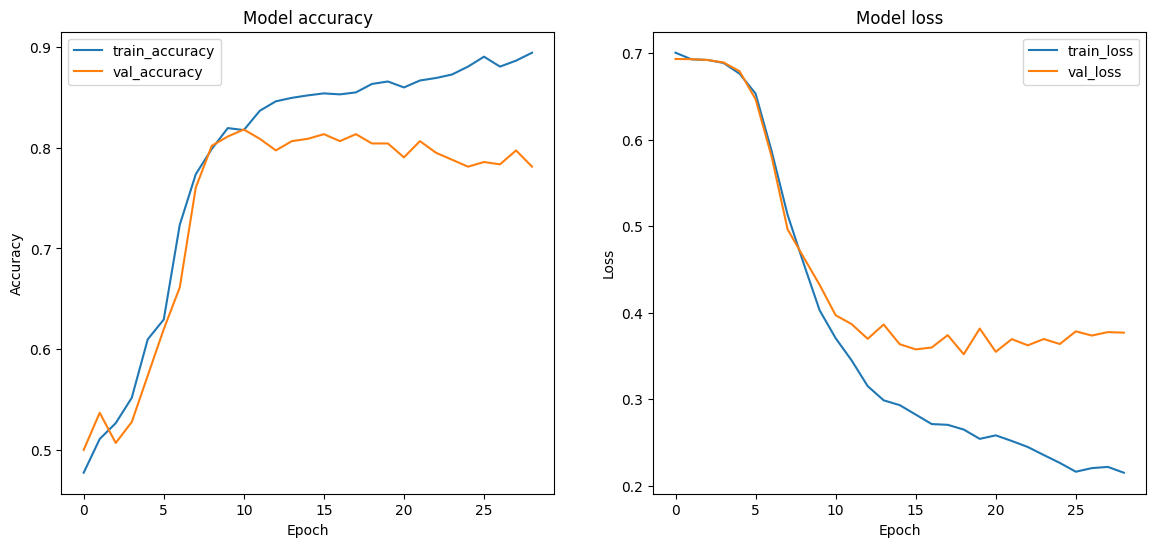

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(history_cnn.history['accuracy'], label='train_accuracy')
ax1.plot(history_cnn.history['val_accuracy'], label='val_accuracy')
ax1.set_title('Model accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(history_cnn.history['loss'], label='train_loss')
ax2.plot(history_cnn.history['val_loss'], label='val_loss')
ax2.set_title('Model loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()

The classification report shows that the CNN model has performed well on both "Normal" and "Pathogenic" classes, with an overall accuracy of 79%.
The precision, recall, and F1-scores are high for both classes, indicating that the model can reliably distinguish between "Normal" and "Pathogenic" samples.
The balanced metrics across classes demonstrate that the model is not biased towards any particular class, which is crucial for reliable and fair predictions in practical applications.

14/14 [==============================] - 2s 157ms/step
              precision    recall  f1-score   support

           0       0.81      0.76      0.78       219
           1       0.77      0.82      0.80       219

    accuracy                           0.79       438
   macro avg       0.79      0.79      0.79       438
weighted avg       0.79      0.79      0.79       438



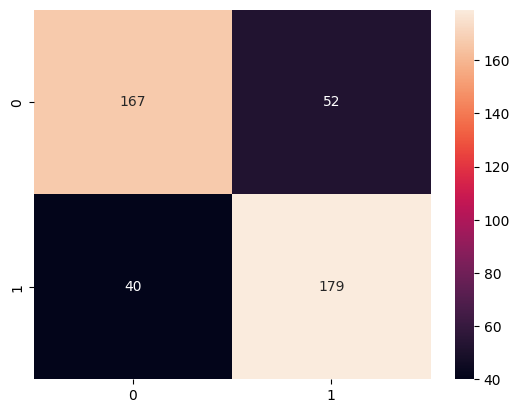

In [8]:
y_pred = cnn_model.predict(test_generator)
y_pred = np.round(y_pred).astype(int)
print(classification_report(test_generator.classes, y_pred))
cm = confusion_matrix(test_generator.classes, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

CNN+RNN : HYBRID MODEL :
This model combines the spatial feature extraction capabilities of CNNs with the sequence processing abilities of RNNs.
The CNN layers extract features from the input images.
The Dense and Dropout layers process and regularize these features.
The Reshape layer prepares the features for the LSTM layer.
The Bidirectional LSTM layer captures temporal dependencies in both directions.
The final Dense layer provides the binary classification output.

In [11]:
input_shape = (img_height, img_width, 3)
input_layer = Input(shape=input_shape)

cnn_layer = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten()
])

cnn_output = cnn_layer(input_layer)
cnn_output = Dense(128, activation='relu')(cnn_output)
cnn_output = Dropout(0.5)(cnn_output)
cnn_output = Reshape((128, 1))(cnn_output)

rnn_layer = Bidirectional(LSTM(64))(cnn_output)
output_layer = Dense(1, activation='sigmoid')(rnn_layer)

cnn_rnn_model = Model(inputs=input_layer, outputs=output_layer)
cnn_rnn_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
cnn_rnn_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 86528)             93248     
                                                                 
 dense_3 (Dense)             (None, 128)               11075712  
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 reshape (Reshape)           (None, 128, 1)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 128)              33792     
 l)                                                              
                                                             

In [12]:
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.2, min_lr=1e-6),
    ModelCheckpoint('best_cnn_rnn_model.h5', save_best_only=True)
]

history_cnn_rnn = cnn_rnn_model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=callbacks
)


Epoch 1/100
64/64 [==============================] - 50s 748ms/step - loss: 0.6934 - accuracy: 0.4857 - val_loss: 0.6932 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/100
64/64 [==============================] - 47s 732ms/step - loss: 0.6934 - accuracy: 0.4951 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/100
64/64 [==============================] - 47s 728ms/step - loss: 0.6931 - accuracy: 0.5094 - val_loss: 0.6931 - val_accuracy: 0.5184 - lr: 1.0000e-04
Epoch 4/100
64/64 [==============================] - 47s 731ms/step - loss: 0.6932 - accuracy: 0.4936 - val_loss: 0.6931 - val_accuracy: 0.5161 - lr: 1.0000e-04
Epoch 5/100
64/64 [==============================] - 47s 737ms/step - loss: 0.6932 - accuracy: 0.4931 - val_loss: 0.6931 - val_accuracy: 0.4977 - lr: 1.0000e-04
Epoch 6/100
64/64 [==============================] - 47s 741ms/step - loss: 0.6931 - accuracy: 0.5157 - val_loss: 0.6931 - val_accuracy: 0.5276 - lr: 1.0000e-04
Epoch 7/100
64/64 [===============

The model's accuracy and loss indicate that it is not learning effectively, remaining around chance level (50% accuracy and 0.693 loss).
The training and validation accuracy improvements are minimal, suggesting issues with model architecture, data preprocessing, or feature extraction.

In [13]:
test_loss, test_acc = cnn_rnn_model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc * 100:.2f}%')


14/14 [==============================] - 3s 176ms/step - loss: 0.6932 - accuracy: 0.5023
Test Accuracy: 50.23%


Given that the training accuracy and validation accuracy were also around 50%, this is likely an issue of underfitting where the model has not learned the underlying patterns in the training data. I think that we should repeat the model with less complexities and maybe change or optimize the hyperparameters .

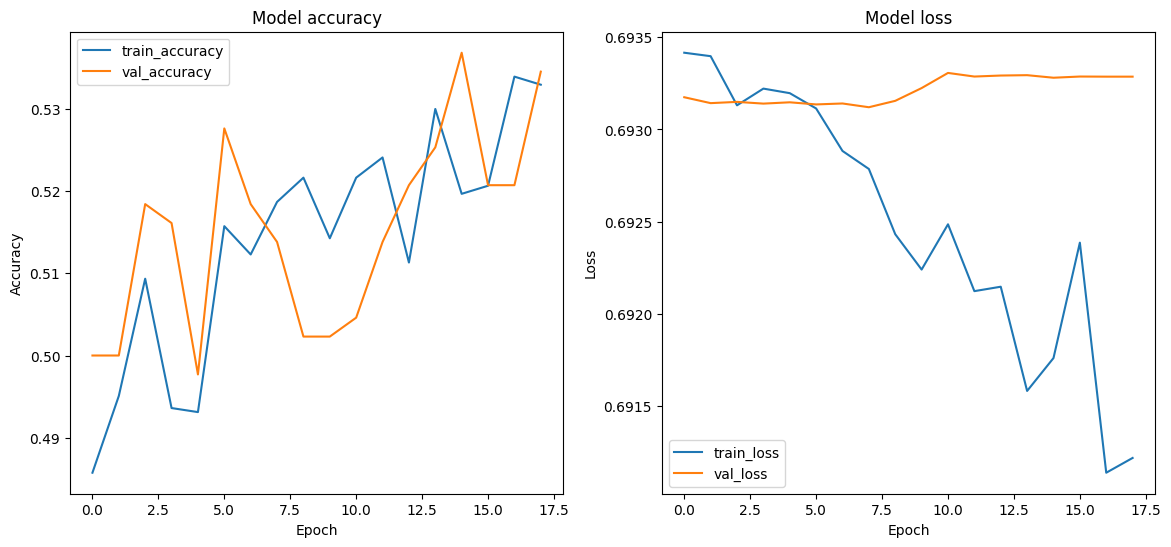

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(history_cnn_rnn.history['accuracy'], label='train_accuracy')
ax1.plot(history_cnn_rnn.history['val_accuracy'], label='val_accuracy')
ax1.set_title('Model accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(history_cnn_rnn.history['loss'], label='train_loss')
ax2.plot(history_cnn_rnn.history['val_loss'], label='val_loss')
ax2.set_title('Model loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()


14/14 [==============================] - 3s 167ms/step
              precision    recall  f1-score   support

           0       0.51      0.13      0.21       219
           1       0.50      0.87      0.64       219

    accuracy                           0.50       438
   macro avg       0.51      0.50      0.42       438
weighted avg       0.51      0.50      0.42       438



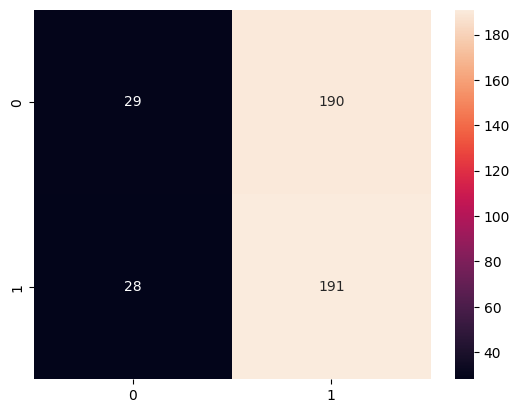

In [15]:
y_pred = cnn_rnn_model.predict(test_generator)
y_pred = np.round(y_pred).astype(int)
print(classification_report(test_generator.classes, y_pred))
cm = confusion_matrix(test_generator.classes, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

VGG16 Model Structure

In [16]:
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
for layer in vgg16_base.layers:
    layer.trainable = False

vgg16_model = Sequential([
    vgg16_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

vgg16_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
vgg16_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_5 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21,137,729
Trainable params: 6,423,041
Non-trainable params: 14,714,688
_________________________________________________________________


In [17]:
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.2, min_lr=1e-6),
    ModelCheckpoint('best_vgg16_model.h5', save_best_only=True)
]

history_vgg16 = vgg16_model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=callbacks
)


Epoch 1/100
64/64 [==============================] - 160s 2s/step - loss: 0.7260 - accuracy: 0.5512 - val_loss: 0.6396 - val_accuracy: 0.6452 - lr: 1.0000e-04
Epoch 2/100
64/64 [==============================] - 157s 2s/step - loss: 0.6392 - accuracy: 0.6260 - val_loss: 0.6191 - val_accuracy: 0.5806 - lr: 1.0000e-04
Epoch 3/100
64/64 [==============================] - 158s 2s/step - loss: 0.5806 - accuracy: 0.7072 - val_loss: 0.5607 - val_accuracy: 0.7788 - lr: 1.0000e-04
Epoch 4/100
64/64 [==============================] - 156s 2s/step - loss: 0.5455 - accuracy: 0.7303 - val_loss: 0.5562 - val_accuracy: 0.6659 - lr: 1.0000e-04
Epoch 5/100
64/64 [==============================] - 159s 2s/step - loss: 0.5153 - accuracy: 0.7549 - val_loss: 0.5283 - val_accuracy: 0.7028 - lr: 1.0000e-04
Epoch 6/100
64/64 [==============================] - 157s 2s/step - loss: 0.4760 - accuracy: 0.7928 - val_loss: 0.5012 - val_accuracy: 0.8018 - lr: 1.0000e-04
Epoch 7/100
64/64 [===========================

Training Progress:
The model starts with a high initial loss and low accuracy but quickly learns, with both training and validation accuracy improving over the epochs.
Validation Performance:
Validation accuracy fluctuates, indicating the model's sensitivity to validation data.
There is a concern of overfitting, as validation loss and accuracy do not improve significantly after certain epochs.
Learning Rate Schedule:
Learning rate reduction helps to fine-tune the model, preventing large weight updates that could disrupt the training progress.
Model Generalization:
The model generalizes well initially but shows signs of overfitting as training accuracy continues to increase while validation accuracy plateaus or fluctuates.

14/14 [==============================] - 28s 2s/step - loss: 0.3939 - accuracy: 0.7831
Test Accuracy: 78.31%


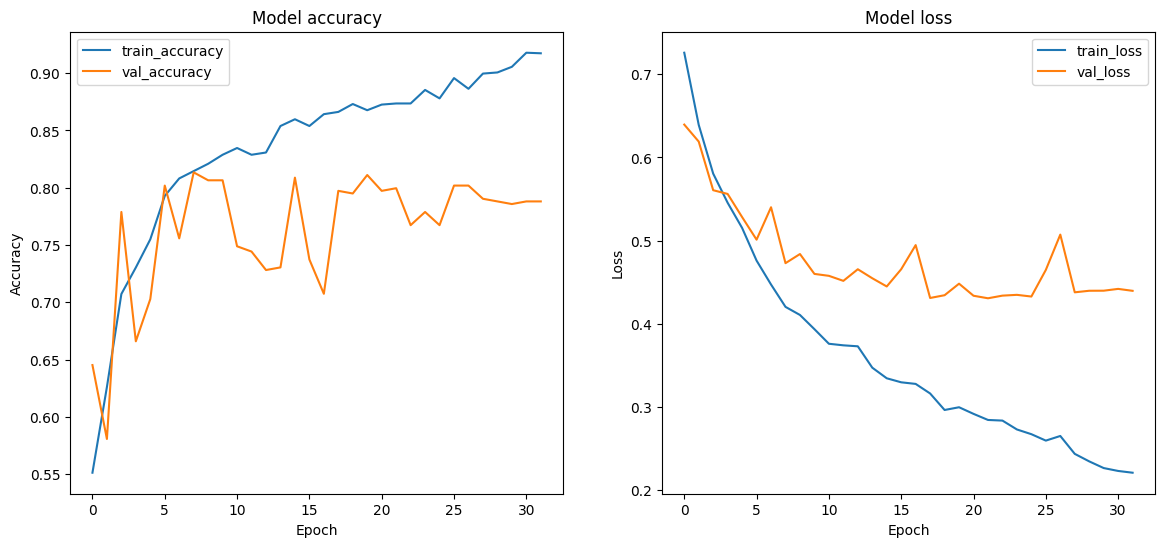

14/14 [==============================] - 29s 2s/step
              precision    recall  f1-score   support

           0       0.76      0.83      0.79       219
           1       0.81      0.74      0.77       219

    accuracy                           0.78       438
   macro avg       0.79      0.78      0.78       438
weighted avg       0.79      0.78      0.78       438



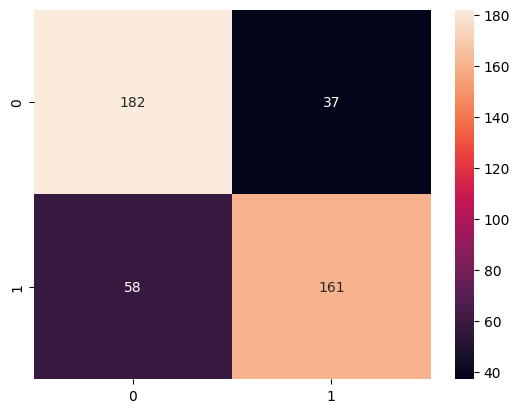

In [18]:
test_loss, test_acc = vgg16_model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc * 100:.2f}%')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(history_vgg16.history['accuracy'], label='train_accuracy')
ax1.plot(history_vgg16.history['val_accuracy'], label='val_accuracy')
ax1.set_title('Model accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax2.plot(history_vgg16.history['loss'], label='train_loss')
ax2.plot(history_vgg16.history['val_loss'], label='val_loss')
ax2.set_title('Model loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
plt.show()
y_pred = vgg16_model.predict(test_generator)
y_pred = np.round(y_pred).astype(int)
print(classification_report(test_generator.classes, y_pred))
cm = confusion_matrix(test_generator.classes, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

The test accuracy of 78.31% indicates that the model performs reasonably well on unseen data. However, it also shows that there is room for improvement to enhance the generalization capability of the model.

Class 0 (Normal):

Precision: 0.81
Of the instances predicted as Normal, 81% were correctly classified.
Recall: 0.76
Of the actual Normal instances, 76% were correctly identified.
F1-Score: 0.78
Harmonic mean of precision and recall, indicating a balance between the two metrics.
Class 1 (Pathogenic):

Precision: 0.77
Of the instances predicted as Pathogenic, 77% were correctly classified.
Recall: 0.82
Of the actual Pathogenic instances, 82% were correctly identified.
F1-Score: 0.80
Indicates a balance between precision and recall.
Overall Accuracy: 0.79

The model correctly classified 79% of the test instances.
Macro Average: 0.79

Average of precision, recall, and f1-score for both classes.
Weighted Average: 0.79

Average of precision, recall, and f1-score, weighted by the number of true instances for each class.

ResNet50 model :

In [19]:
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

for layer in resnet50_base.layers:
    layer.trainable = False

resnet50_model = Sequential([
    resnet50_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

resnet50_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
resnet50_model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_4 (Flatten)         (None, 100352)            0         
                                                                 
 dense_7 (Dense)             (None, 256)               25690368  
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 257       
                                                                 
Total params: 49,278,337
Trainable params: 25,690,625
Non-trainable params: 23,587,712
_________________________________________________________________


In [21]:
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.2, min_lr=1e-6),
    ModelCheckpoint('best_resnet50_model.h5', save_best_only=True)
]

history_resnet50 = resnet50_model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=callbacks
)


Epoch 1/100
64/64 [==============================] - 98s 1s/step - loss: 0.8674 - accuracy: 0.4911 - val_loss: 0.7083 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/100
64/64 [==============================] - 94s 1s/step - loss: 0.6992 - accuracy: 0.4779 - val_loss: 0.6930 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/100
64/64 [==============================] - 93s 1s/step - loss: 0.6936 - accuracy: 0.4882 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 4/100
64/64 [==============================] - 93s 1s/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 5/100
64/64 [==============================] - 93s 1s/step - loss: 0.6931 - accuracy: 0.4961 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 6/100
64/64 [==============================] - 94s 1s/step - loss: 0.6931 - accuracy: 0.4941 - val_loss: 0.6931 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 7/100
64/64 [==============================] -

14/14 [==============================] - 17s 1s/step - loss: 0.6932 - accuracy: 0.5000
Test Accuracy: 50.00%


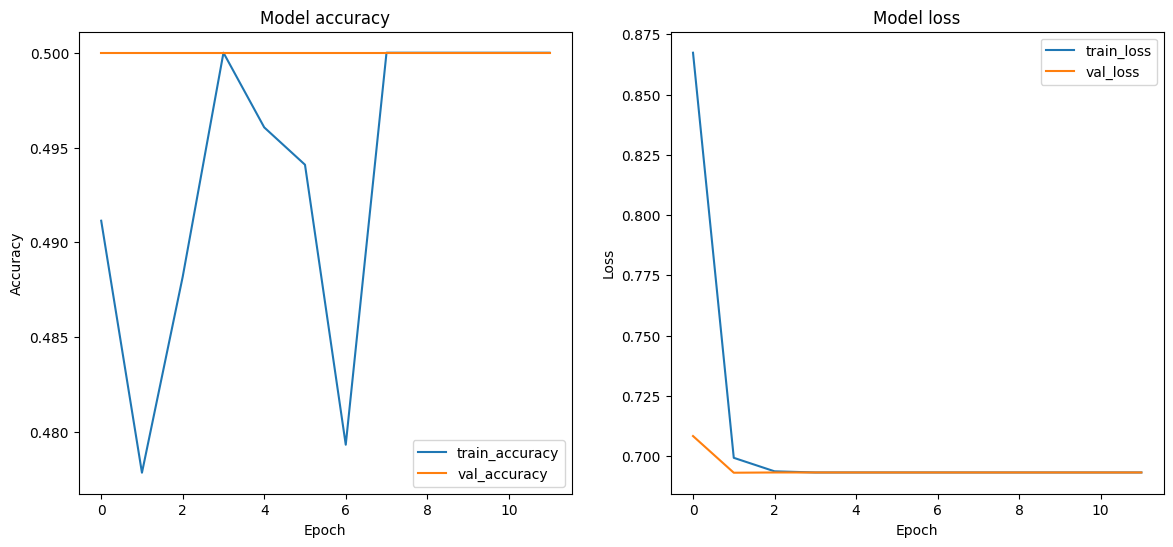

14/14 [==============================] - 17s 1s/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       219
           1       0.50      1.00      0.67       219

    accuracy                           0.50       438
   macro avg       0.25      0.50      0.33       438
weighted avg       0.25      0.50      0.33       438



C:\Users\Badis\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Badis\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Badis\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


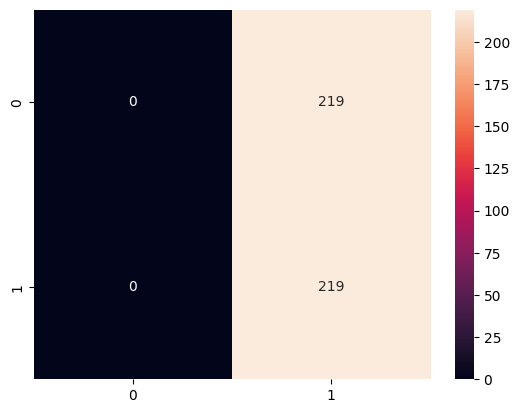

In [22]:
test_loss, test_acc = resnet50_model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(history_resnet50.history['accuracy'], label='train_accuracy')
ax1.plot(history_resnet50.history['val_accuracy'], label='val_accuracy')
ax1.set_title('Model accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(history_resnet50.history['loss'], label='train_loss')
ax2.plot(history_resnet50.history['val_loss'], label='val_loss')
ax2.set_title('Model loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()
y_pred = resnet50_model.predict(test_generator)
y_pred = np.round(y_pred).astype(int)
print(classification_report(test_generator.classes, y_pred))
cm = confusion_matrix(test_generator.classes, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

in our case The ResNet50 model's performance indicates significant challenges in learning from the current dataset and setup. By addressing potential preprocessing issues, enhancing data augmentation, fine-tuning the model architecture, and considering additional feature engineering and hyperparameter tuning, it may be possible to improve the model's ability to learn and generalize effectively . but our data needs to be more augmented. so for the Resnet50 it s one of the best CNN models but it depends on the data size so I think that we should eliminate this model.